In [933]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, to_date, dayofweek, hour, lag, mean, lit, when,avg
from pyspark.sql.window import Window
import json
from pyspark.sql.functions import rand, isnan, when
from pyspark.sql.types import FloatType
from pyspark.sql.functions import rand, round
from keras.callbacks import TensorBoard
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, monotonically_increasing_id
from pyspark.sql.types import FloatType
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import datetime
from tensorflow.keras.utils import to_categorical

# Initialize a SparkSession
spark = SparkSession.builder.appName("PredictiveMaintenance").getOrCreate()

# Load your dataset into a PySpark DataFrame
df = spark.read.csv('/Users/mac/Downloads/rul.csv', header=True, inferSchema=True)
df.count()
df = df.limit(1000)
df.count()
# Assuming 'date_insertion' is the correct timestamp column based on your dataset schema
# Adjust the following transformations accordingly:

# Extract JSON fields function
def extract_from_json(column, key):
    try:
        json_data = json.loads(column.replace("'", "\""))
        return json_data.get(key, None)
    except:
        return None

# Registering the UDF
extract_from_json_udf = udf(extract_from_json)

# Step 1: Extracting 'oil_value' and 'fuel_liters'
df = df.withColumn("oil_value", extract_from_json_udf(col("details"), lit("oil_value")))
df = df.withColumn("fuel_liters", extract_from_json_udf(col("details"), lit("fuel_liters")))

# Step 2: Creating time-based features
# df = df.withColumn("date_insertion", to_date(col("date_insertion")))
df = df.withColumn("day_of_week", dayofweek(col("date_insertion")))
df = df.withColumn("hour_of_day", hour(col("date_insertion")))



# Step 4: Aggregate readings on a daily basis
daily_avg_df = df.groupBy("thing_id", "date_insertion").agg(mean("power_supply_voltage").alias("daily_avg_voltage"))
df = df.join(daily_avg_df, ["thing_id", "date_insertion"], "left")

# Step 5: Create binary indicator for 'engine_status'
df = df.withColumn("engine_alert", when(col("engine_status") == "Abnormal", 1).otherwise(0))

# Define a UDF to generate random values within a range
def random_value(min_value, max_value):
    return (rand() * (max_value - min_value) + min_value).cast(FloatType())

# random_value_udf = udf(random_value, FloatType())

# Set min and max values for 'oil_value' and 'fuel_liters'
oil_value_min, oil_value_max = 0, 4
fuel_liters_min, fuel_liters_max = 0, 60

fuel_liters_mi, fuel_liters_ma = 2, 6


# Replace null values with random numbers
# Replace null values with random numbers and round to 1 decimal place
# df = df.withColumn("oil_value", when(df['oil_value'].isNull(), round((rand() * (oil_value_max - oil_value_min) + oil_value_min), 1)).otherwise(df['oil_value']))


# Sample range for oil values
oil_value_min = 0.5
oil_value_max = 5.0

df = df.orderBy('thing_id', 'date_insertion')

from pyspark.sql.functions import row_number
from pyspark.sql.window import Window

window = Window.partitionBy('thing_id').orderBy('date_insertion')
df = df.withColumn('row_num', row_number().over(window))

from pyspark.sql.functions import count

window = Window.partitionBy('thing_id')
df = df.withColumn('total_rows', count('*').over(window))

from pyspark.sql.functions import when, rand

oil_value_max = 10  # replace with your actual maximum oil value
oil_value_min = 0    # replace with your actual minimum oil value

from pyspark.sql.functions import when, rand, round, col
df = df.withColumn("oil_value", col("oil_value").cast("float"))
# Define the ranges for the oil values
# Define the ranges for the oil values
first_range_min = 4
first_range_max = 6
second_range_min = 3
second_range_max = 6
third_range_min = 2
third_range_max = 5
fourth_range_min = 2
fourth_range_max = 4


first_range_min2 = 0.014
first_range_max2 = 0.017
second_range_min2 = 0.015
second_range_max2 = 0.018
third_range_min2 = 0.016
third_range_max2 = 0.018
fourth_range_min2 = 0.018
fourth_range_max2 = 0.022



# Define a window partitioned by 'thing_id' and ordered by 'date_insertion'
window = Window.partitionBy('thing_id').orderBy('date_insertion')
total_window = Window.partitionBy('thing_id')

# Calculate the row number and total rows for each 'thing_id'
df = df.withColumn('row_num', row_number().over(window))
df = df.withColumn('total_rows', count('*').over(total_window))

# Define the thresholds for the different periods
df = df.withColumn('first_threshold', (col('total_rows') * 0.6))
df = df.withColumn('second_threshold', (col('total_rows') * 0.8))
df = df.withColumn('third_threshold', (col('total_rows') * 0.9))

# Generate the oil values
df = df.withColumn('oil_value', 
                   when(df['oil_value'].isNull() & (col('row_num') <= col('first_threshold')), 
                        round(rand() * (first_range_max - first_range_min) + first_range_min, 1))
                   .when(df['oil_value'].isNull() & (col('row_num') > col('first_threshold')) & (col('row_num') <= col('second_threshold')), 
                         round(rand() * (second_range_max - second_range_min) + second_range_min, 1))
                   .when(df['oil_value'].isNull() & (col('row_num') > col('second_threshold')) & (col('row_num') <= col('third_threshold')), 
                         round(rand() * (third_range_max - third_range_min) + third_range_min, 1))
                   .when(df['oil_value'].isNull() & (col('row_num') > col('third_threshold')), 
                         round(rand() * (fourth_range_max - fourth_range_min) + fourth_range_min, 1))
                   .otherwise(df['oil_value']))


# create an empty fuel change colunm
df = df.withColumn('fuel_change', lit(None).cast(FloatType()))

# generate rhe fule change values
df = df.withColumn('fuel_change', 
                   when(df['fuel_change'].isNull() & (col('row_num') <= col('first_threshold')), 
                        round(rand() * (first_range_max2 - first_range_min2) + first_range_min2, 3))
                   .when(df['fuel_change'].isNull() & (col('row_num') > col('first_threshold')) & (col('row_num') <= col('second_threshold')), 
                         round(rand() * (second_range_max2 - second_range_min2) + second_range_min2, 3))
                   .when(df['fuel_change'].isNull() & (col('row_num') > col('second_threshold')) & (col('row_num') <= col('third_threshold')), 
                         round(rand() * (third_range_max2 - third_range_min2) + third_range_min2, 3))
                   .when(df['fuel_change'].isNull() & (col('row_num') > col('third_threshold')), 
                         round(rand() * (fourth_range_max2 - fourth_range_min2) + fourth_range_min2, 3))
                   .otherwise(df['fuel_change']))

# Drop the auxiliary columns
df = df.drop('row_num', 'total_rows', 'first_threshold', 'second_threshold', 'third_threshold')


# =====================================
# =====================================
# =====================================
# =====================================
# =====================================
# =====================================
# =====================================
# fuel change


























df = df.withColumn("fuel_liters", when(df['fuel_liters'].isNull(), round((rand() * (fuel_liters_max - fuel_liters_min) + fuel_liters_min), 1)).otherwise(df['fuel_liters']))
# df = df.withColumn("fuel_change", when(df['fuel_liters'].isNull(), round((rand() * (fuel_liters_ma - fuel_liters_mi) + fuel_liters_mi), 1)).otherwise(df['fuel_liters']))








# Step 6: Generate interaction features
# df = df.withColumn("voltage_current_interaction", col("power_supply_voltage") * col("battery_current"))

# Step 3: Calculating rate of change for 'battery_current'
windowSpec = Window.partitionBy("thing_id").orderBy("date_insertion")
df = df.withColumn("battery_current_change", col("power_supply_voltage") - lag("power_supply_voltage", 1).over(windowSpec))


df = df.select("thing_id", "date_insertion", "speed", "total_km", "engine_status", "power_supply_voltage" ,"oil_value","fuel_change", "fuel_liters",  "battery_current_change", "daily_avg_voltage")


from pyspark.sql import Window
from pyspark.sql.functions import lag, avg, stddev

# Define a window
window = Window.orderBy('date_insertion').rowsBetween(-9, 0)  # assuming 'date_insertion' is your time column

# Calculate rolling averages and standard deviations
# df = df.withColumn('speed_avg', avg(df['speed']).over(window))
# df = df.withColumn('oil_value_std', stddev(df['oil_value']).over(window))

# Calculate changes between consecutive readings
# df = df.withColumn('speed_change', df['speed'] - lag(df['speed']).over(Window.orderBy('date_insertion')))
# df = df.withColumn('fuel_change', df['fuel_liters'] - lag(df['fuel_liters']).over(Window.orderBy('date_insertion')))
# df = df.withColumn('fuel_change', (rand() * 4 + 2).cast("int"))#replace all fuel_chnages values with random values between 2 and 6



# Step 7: Calculate rolling average


# Define a Window specification 
# windowSpec = Window.orderBy('date_insertion').rowsBetween(-4, 0)  # 5 rows including current row

# Calculate rolling average
# df = df.withColumn('oil_quality_rolling_avg', avg(df['oil_value']).over(windowSpec))

df = df.withColumn("car_age", when(rand() < 0.7, "old").otherwise("new"))

# Show the first 5 rows of the DataFrame
df.show()
df.count()




+--------+-------------------+-----+--------+-------------+--------------------+---------+-----------+-----------+----------------------+------------------+-------+
|thing_id|     date_insertion|speed|total_km|engine_status|power_supply_voltage|oil_value|fuel_change|fuel_liters|battery_current_change| daily_avg_voltage|car_age|
+--------+-------------------+-----+--------+-------------+--------------------+---------+-----------+-----------+----------------------+------------------+-------+
|    1599|2024-02-28 00:01:03|    0|12125512|            1|               13.92|      5.1|      0.016|        6.4|                  NULL|             13.92|    new|
|    1599|2024-02-28 00:01:04|    0|12125512|            1|               13.87|      5.1|      0.017|       15.9|  -0.05000000000000071|14.032222222222222|    old|
|    1599|2024-02-28 00:01:04|    0|12125512|            1|               13.92|      5.5|      0.016|       41.0|   0.05000000000000071|14.032222222222222|    old|
|    1599|

1000

In [934]:
from pyspark.sql import Window
from pyspark.sql.functions import max, col

df = df.withColumn('row_number', monotonically_increasing_id())


# Define a window partitioned by machine ID, ordered by timestamp in descending order
# Define a window partitioned by machine ID, ordered by timestamp in descending order
window = Window.partitionBy('thing_id').orderBy(col('date_insertion').desc())

# Create a new column 'failure_km' that contains the kilometers at the time of failure for each machine
df = df.withColumn('failure_km', max('total_km').over(window))



# Create the target variable 'km_until_failure' by subtracting 'journey' from 'failure_km'
df = df.withColumn('km_until_failure', col('failure_km') - col('total_km'))

# Drop the 'failure_km' column as it's no longer needed
df = df.drop('failure_km')
# Order by the row number column to get back to the original order
df = df.orderBy('row_number')

# Drop the row number column
df = df.drop('row_number')

df.show()

# Show the DataFrame with the new target variable

from pyspark.sql.functions import asc, desc

# df = df.sort(asc('date_insertion'))
# df = df.orderBy('date_insertion')

df.count()

+--------+-------------------+-----+--------+-------------+--------------------+---------+-----------+-----------+----------------------+------------------+-------+----------------+
|thing_id|     date_insertion|speed|total_km|engine_status|power_supply_voltage|oil_value|fuel_change|fuel_liters|battery_current_change| daily_avg_voltage|car_age|km_until_failure|
+--------+-------------------+-----+--------+-------------+--------------------+---------+-----------+-----------+----------------------+------------------+-------+----------------+
|    1599|2024-02-28 00:01:03|    0|12125512|            1|               13.92|      5.1|      0.016|        6.4|                  NULL|             13.92|    new|             247|
|    1599|2024-02-28 00:01:04|    0|12125512|            1|               13.87|      5.1|      0.017|       15.9|  -0.05000000000000071|14.032222222222222|    old|             247|
|    1599|2024-02-28 00:01:04|    0|12125512|            1|               13.92|      5.5|

1000

In [935]:
df = df.fillna('ffill')  # Forward fill to handle missing values
df.show()
df.count()


+--------+-------------------+-----+--------+-------------+--------------------+---------+-----------+-----------+----------------------+------------------+-------+----------------+
|thing_id|     date_insertion|speed|total_km|engine_status|power_supply_voltage|oil_value|fuel_change|fuel_liters|battery_current_change| daily_avg_voltage|car_age|km_until_failure|
+--------+-------------------+-----+--------+-------------+--------------------+---------+-----------+-----------+----------------------+------------------+-------+----------------+
|    1599|2024-02-28 00:01:03|    0|12125512|            1|               13.92|      5.1|      0.016|        6.4|                  NULL|             13.92|    new|             247|
|    1599|2024-02-28 00:01:04|    0|12125512|            1|               13.87|      5.1|      0.017|       15.9|  -0.05000000000000071|14.032222222222222|    old|             247|
|    1599|2024-02-28 00:01:04|    0|12125512|            1|               13.92|      5.5|

1000

In [936]:
from pyspark.sql.functions import avg, stddev, min, max, sum, col
from pyspark.sql.window import Window

# Define a window specification for rolling calculations (adjust window size as needed)
window_spec = Window.partitionBy().orderBy("date_insertion").rowsBetween(-9, 0)

# Calculate rolling means
df = df.withColumn('oil_rolling_mean', avg(col('oil_value')).over(window_spec))
df = df.withColumn('fuel_rolling_mean', avg(col('fuel_liters')).over(window_spec))
df = df.withColumn('battery_rolling_mean', avg(col('power_supply_voltage')).over(window_spec))

# Calculate rolling standard deviations
df = df.withColumn('oil_rolling_stddev', stddev(col('oil_value')).over(window_spec))
df = df.withColumn('fuel_rolling_stddev', stddev(col('fuel_liters')).over(window_spec))
df = df.withColumn('battery_rolling_stddev', stddev(col('power_supply_voltage')).over(window_spec))

# Calculate cumulative sums
df = df.withColumn('oil_cumsum', sum(col('oil_value')).over(window_spec))
df = df.withColumn('fuel_cumsum', sum(col('fuel_liters')).over(window_spec))
df = df.withColumn('battery_cumsum', sum(col('power_supply_voltage')).over(window_spec))

# Calculate min and max values
df = df.withColumn('oil_min', min(col('oil_value')).over(window_spec))
df = df.withColumn('fuel_min', min(col('fuel_liters')).over(window_spec))
df = df.withColumn('battery_min', min(col('power_supply_voltage')).over(window_spec))

df = df.withColumn('oil_max', max(col('oil_value')).over(window_spec))
df = df.withColumn('fuel_max', max(col('fuel_liters')).over(window_spec))
df = df.withColumn('battery_max', max(col('power_supply_voltage')).over(window_spec))
df = df.na.drop()



df.count()

df = df.filter(df.thing_id == 1599)

# from pyspark.sql.functions import desc

# thing_id_counts = df.groupBy('thing_id').count().orderBy(desc('count'))

# To see the 'thing_id' with the most rows
# thing_id_counts.show(1)

df.show(20)
# df.tail(10)
df.count()



24/05/15 00:37:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 0

+--------+-------------------+-----+--------+-------------+--------------------+---------+-----------+-----------+----------------------+------------------+-------+----------------+------------------+------------------+--------------------+-------------------+-------------------+----------------------+------------------+------------------+------------------+-------+--------+-----------+-------+--------+-----------+
|thing_id|     date_insertion|speed|total_km|engine_status|power_supply_voltage|oil_value|fuel_change|fuel_liters|battery_current_change| daily_avg_voltage|car_age|km_until_failure|  oil_rolling_mean| fuel_rolling_mean|battery_rolling_mean| oil_rolling_stddev|fuel_rolling_stddev|battery_rolling_stddev|        oil_cumsum|       fuel_cumsum|    battery_cumsum|oil_min|fuel_min|battery_min|oil_max|fuel_max|battery_max|
+--------+-------------------+-----+--------+-------------+--------------------+---------+-----------+-----------+----------------------+------------------+------

24/05/15 00:37:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 0

999

In [937]:
df.tail(5)

24/05/15 00:37:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 0

[Row(thing_id=1599, date_insertion=datetime.datetime(2024, 2, 28, 2, 9, 3), speed=0, total_km=12125759, engine_status=0, power_supply_voltage=13.0, oil_value=3.4, fuel_change=0.02, fuel_liters='14.2', battery_current_change=0.0, daily_avg_voltage=12.998, car_age='old', km_until_failure=0, oil_rolling_mean=3.0599999999999996, fuel_rolling_mean=28.589999999999996, battery_rolling_mean=13.001999999999999, oil_rolling_stddev=0.5621387729022079, fuel_rolling_stddev=18.236498811144887, battery_rolling_stddev=0.004216370213557982, oil_cumsum=30.599999999999998, fuel_cumsum=285.9, battery_cumsum=130.01999999999998, oil_min=2.3, fuel_min='13.8', battery_min=13.0, oil_max=4.0, fuel_max='7.3', battery_max=13.01),
 Row(thing_id=1599, date_insertion=datetime.datetime(2024, 2, 28, 2, 9, 3), speed=0, total_km=12125759, engine_status=0, power_supply_voltage=13.0, oil_value=3.5, fuel_change=0.02, fuel_liters='36.5', battery_current_change=0.0, daily_avg_voltage=12.998, car_age='old', km_until_failure=0

In [938]:
# Define features and target
# Plotting line plots for each feature
features = [ 'oil_value', 'fuel_change', 'oil_rolling_mean', 'fuel_rolling_mean',
            'oil_rolling_stddev', 'fuel_rolling_stddev',
            'oil_cumsum', 'fuel_cumsum',
            'oil_min', 'fuel_min',
            'oil_max', 'fuel_max']

target = 'km_until_failure'

# Select only the necessary columns
df = df.select(features + [target])

# show the last 20 rows

df.count()


24/05/15 00:37:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 0

999

In [939]:

df.show(20)

# Split the data into training and testing sets
train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)



train_pandas = train_df.toPandas()
test_pandas = test_df.toPandas()


24/05/15 00:37:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 0

+---------+-----------+------------------+------------------+-------------------+-------------------+------------------+------------------+-------+--------+-------+--------+----------------+
|oil_value|fuel_change|  oil_rolling_mean| fuel_rolling_mean| oil_rolling_stddev|fuel_rolling_stddev|        oil_cumsum|       fuel_cumsum|oil_min|fuel_min|oil_max|fuel_max|km_until_failure|
+---------+-----------+------------------+------------------+-------------------+-------------------+------------------+------------------+-------+--------+-------+--------+----------------+
|      5.1|      0.017|               5.1|             11.15|                0.0| 6.7175144212722016|              10.2|              22.3|    5.1|    15.9|    5.1|     6.4|             247|
|      5.5|      0.016| 5.233333333333333|21.099999999999998|0.23094010767585052| 17.876520914316632|              15.7|              63.3|    5.1|    15.9|    5.5|     6.4|             247|
|      5.2|      0.015|             5.225|   

24/05/15 00:37:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 0

24/05/15 00:37:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 00:37:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 0

999


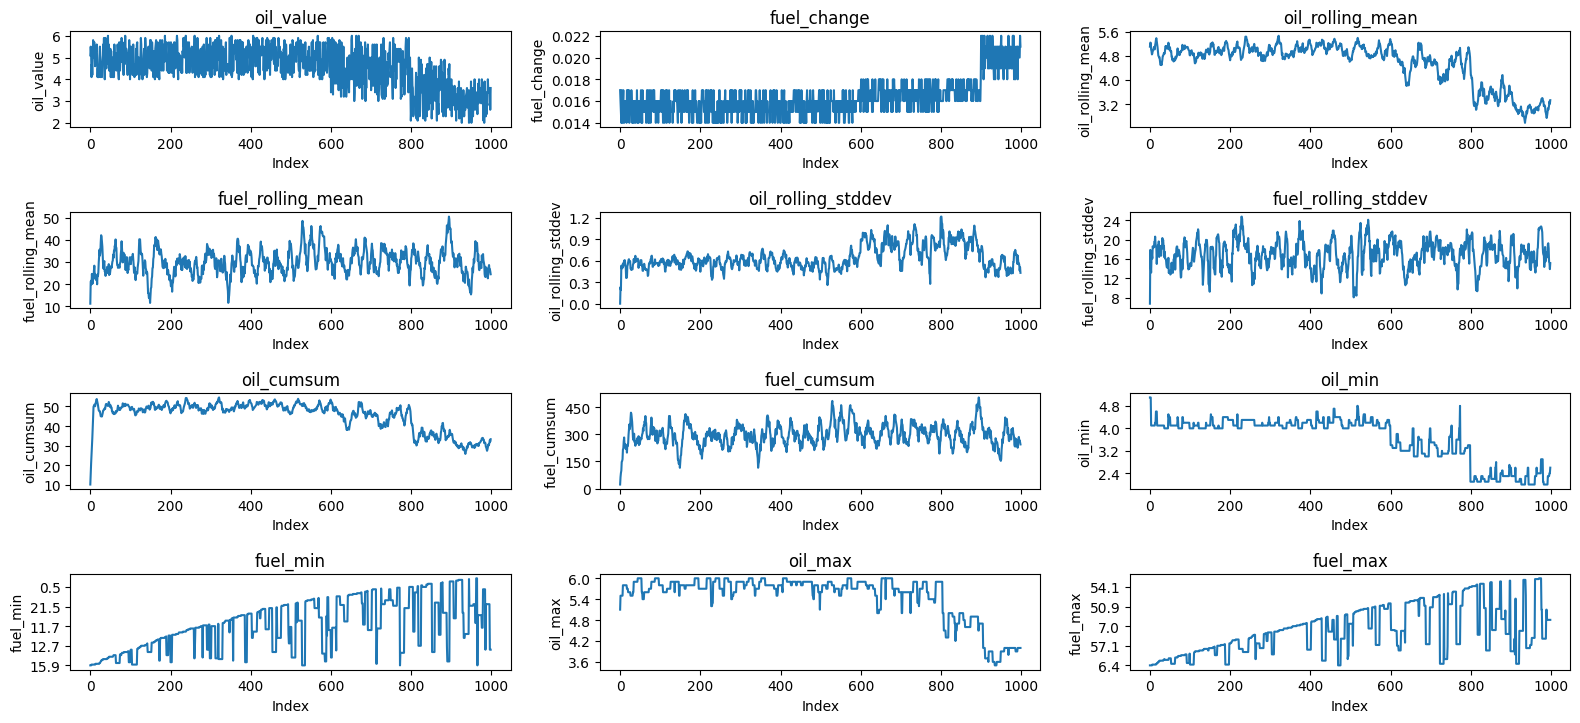

In [940]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator


# Combine train and test data for plotting
combined_pandas = df.toPandas()

total_length = len(combined_pandas)


print(total_length)

# Plotting line plots for each feature
features = [ 'oil_value', 'fuel_change', 'oil_rolling_mean', 'fuel_rolling_mean',
            'oil_rolling_stddev', 'fuel_rolling_stddev',
            'oil_cumsum', 'fuel_cumsum',
            'oil_min', 'fuel_min',
            'oil_max', 'fuel_max']

fig = plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    # plt.subplot(6, 3, i+1)
    # plt.plot(combined_pandas.index, combined_pandas[feature])
    # plt.title(feature)
    # plt.xlabel('Index')
    # plt.ylabel(feature)
    # plt.tight_layout()
    # plt.yticks([float(i) for i in plt.yticks()[0]])
    ax = plt.subplot(6, 3, i+1)
    plt.plot(combined_pandas.index, combined_pandas[feature])
    plt.title(feature)
    plt.xlabel('Index')
    plt.ylabel(feature)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Limit the number of y-axis labels
    plt.tight_layout()

    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)




    
# Show the plot
plt.show()


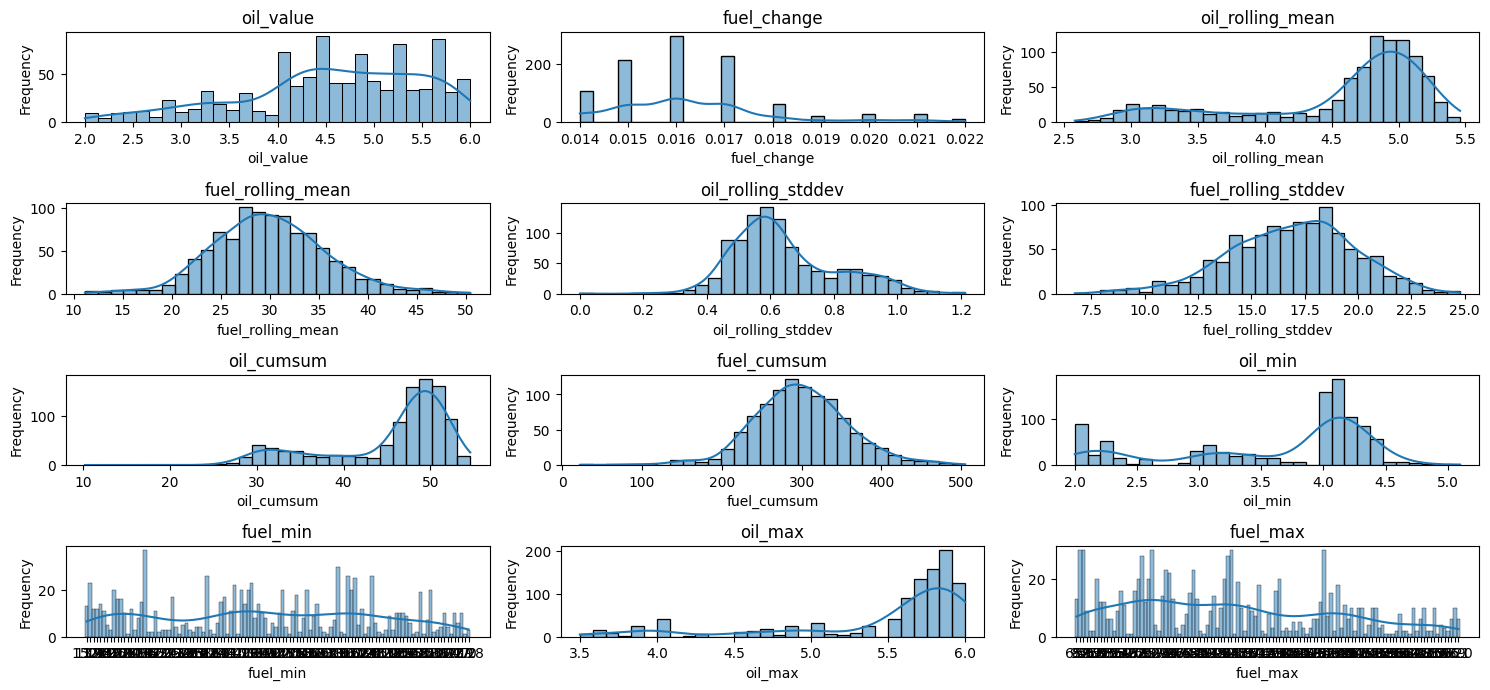

In [941]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(6, 3, i+1)
    sns.histplot(combined_pandas[feature], bins=30, kde=True)
    plt.title(feature)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.tight_layout()

plt.show()


In [942]:
from sklearn.preprocessing import StandardScaler

# Separate features and target
X_train = train_pandas[features].values
y_train = train_pandas[target].values
X_test = test_pandas[features].values
y_test = test_pandas[target].values

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [943]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Dense, Dropout, BatchNormalization

# Build the DNN model
model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=2)


Epoch 1/100


/Users/mac/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 - 1s - 74ms/step - loss: 22926.0098 - val_loss: 31360.6406
Epoch 2/100
19/19 - 0s - 2ms/step - loss: 22484.0801 - val_loss: 30978.4219
Epoch 3/100
19/19 - 0s - 2ms/step - loss: 22034.4766 - val_loss: 30291.9570
Epoch 4/100
19/19 - 0s - 2ms/step - loss: 21538.0645 - val_loss: 29330.9336
Epoch 5/100
19/19 - 0s - 2ms/step - loss: 20870.8105 - val_loss: 28202.8438
Epoch 6/100
19/19 - 0s - 9ms/step - loss: 20304.7578 - val_loss: 26967.7773
Epoch 7/100
19/19 - 0s - 2ms/step - loss: 19711.0117 - val_loss: 25756.2754
Epoch 8/100
19/19 - 0s - 2ms/step - loss: 19252.9102 - val_loss: 24777.4629
Epoch 9/100
19/19 - 0s - 2ms/step - loss: 18518.1328 - val_loss: 23838.6934
Epoch 10/100
19/19 - 0s - 2ms/step - loss: 18043.5781 - val_loss: 22926.3613
Epoch 11/100
19/19 - 0s - 2ms/step - loss: 17797.5977 - val_loss: 22068.4160
Epoch 12/100
19/19 - 0s - 2ms/step - loss: 17116.0371 - val_loss: 21333.2129
Epoch 13/100
19/19 - 0s - 3ms/step - loss: 16549.5879 - val_loss: 20495.3613
Epoch 14/100
19/19 

In [944]:
# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mae = np.mean(np.abs(y_test - y_pred))
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MAE: 102.99491083479258
RMSE: 137.34185536353584


In [945]:
# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the model
mae_rf = np.mean(np.abs(y_test - y_pred_rf))
rmse_rf = np.sqrt(np.mean((y_test - y_pred_rf) ** 2))

print(f'Random Forest MAE: {mae_rf}')
print(f'Random Forest RMSE: {rmse_rf}')

Random Forest MAE: 10.206156862745098
Random Forest RMSE: 26.96061184358382


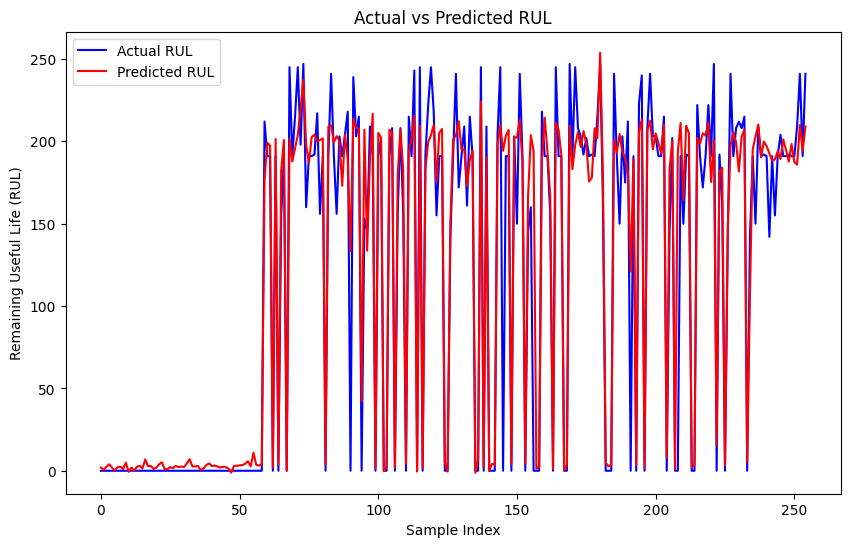

In [946]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test and y_pred are available from the model evaluation step
# y_test = ... (actual RUL values)
# y_pred = ... (predicted RUL values)

# Convert y_test and y_pred to 1D arrays if they are not
y_test = y_test.flatten()
y_pred = y_pred.flatten()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual RUL', color='b')
plt.plot(y_pred, label='Predicted RUL', color='r')
plt.xlabel('Sample Index')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title('Actual vs Predicted RUL')
plt.legend()
plt.show()

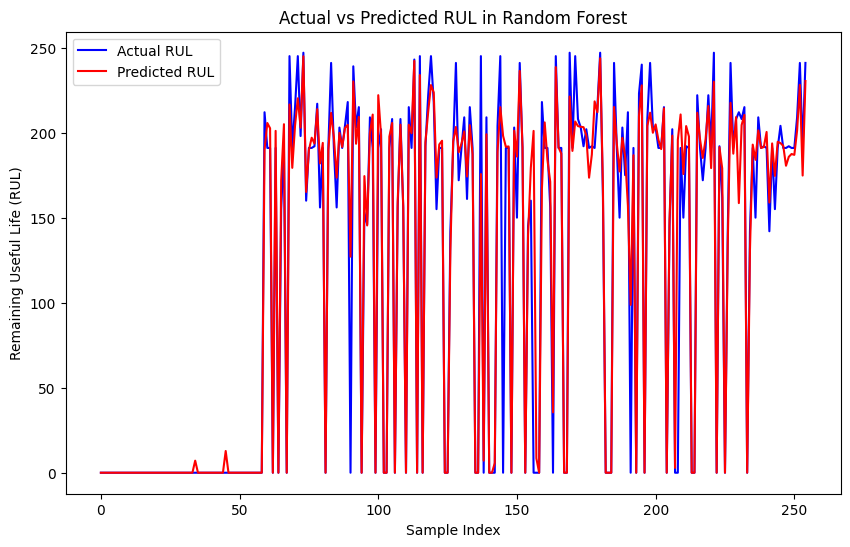

In [947]:
# using random forest

# Assuming y_test and y_pred are available from the model evaluation step
# y_test = ... (actual RUL values)
# y_pred = ... (predicted RUL values)

# Convert y_test and y_pred to 1D arrays if they are not
y_test = y_test.flatten()
y_pred = y_pred.flatten()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual RUL', color='b')
plt.plot(y_pred_rf, label='Predicted RUL', color='r')
plt.xlabel('Sample Index')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title('Actual vs Predicted RUL in Random Forest')
plt.legend()
plt.show()

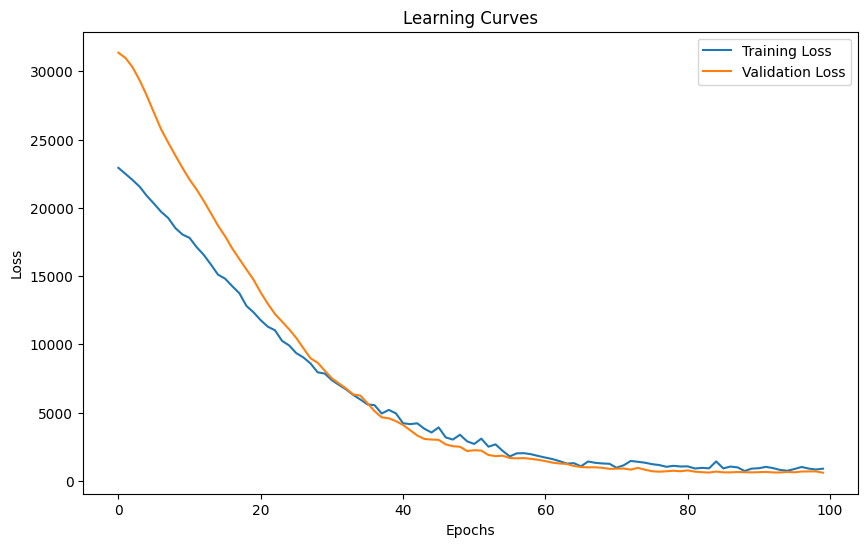

In [948]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()


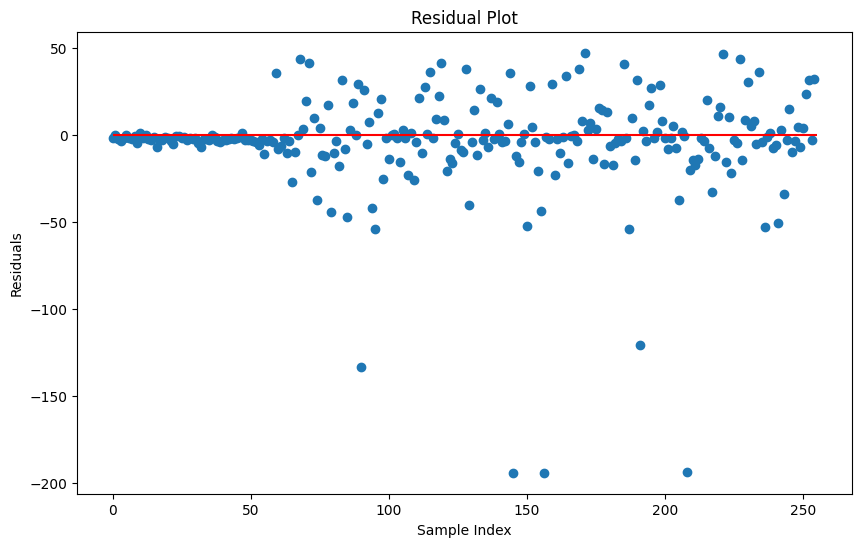

In [949]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals)
plt.hlines(y=0, xmin=0, xmax=len(residuals), colors='r')
plt.xlabel('Sample Index')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


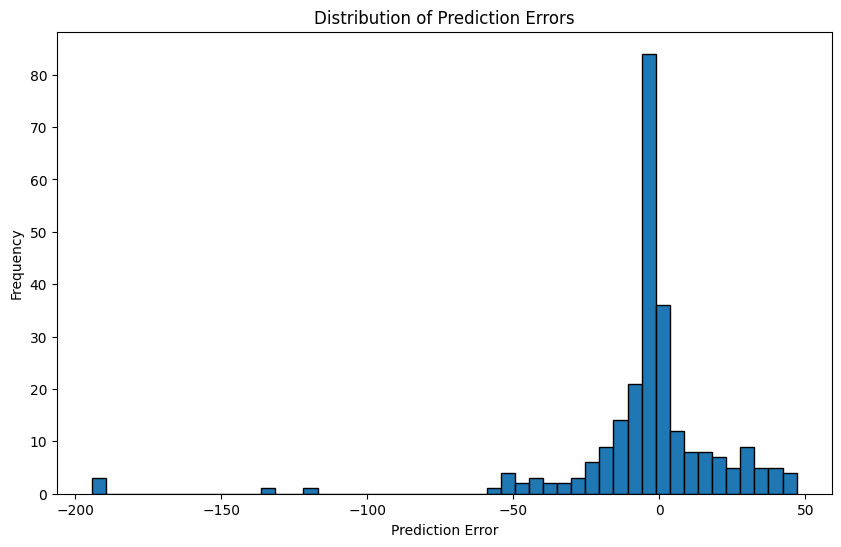

In [950]:
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='k')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()


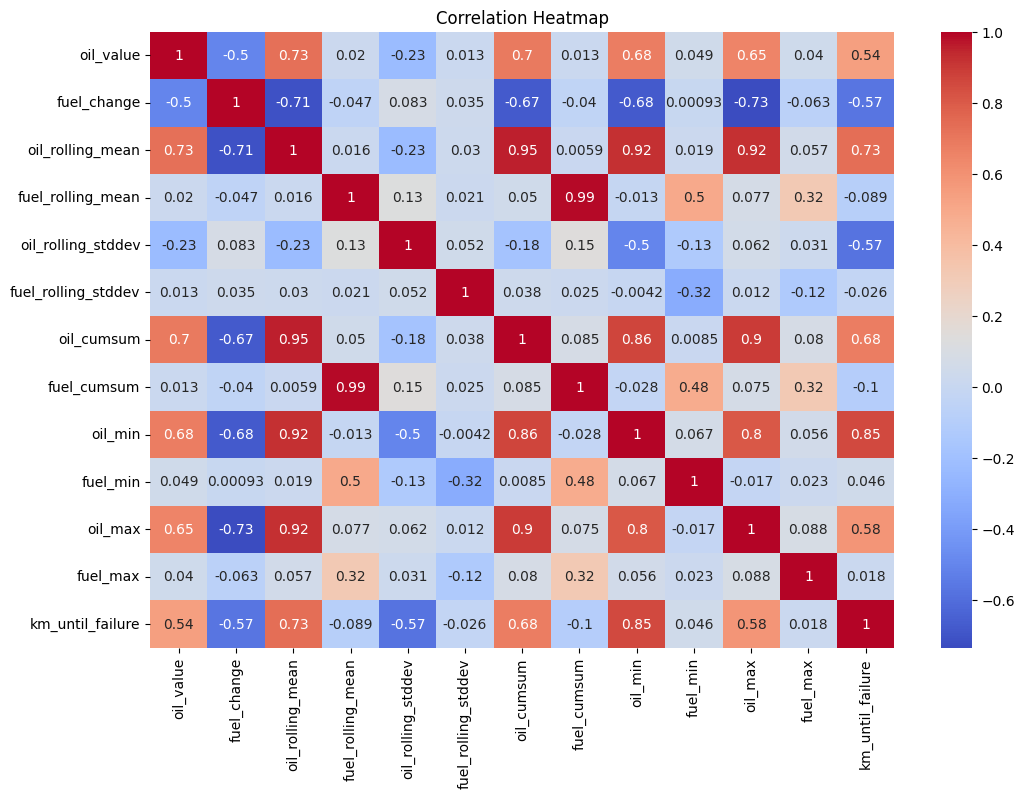

In [951]:
import seaborn as sns

correlation_matrix = train_pandas.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


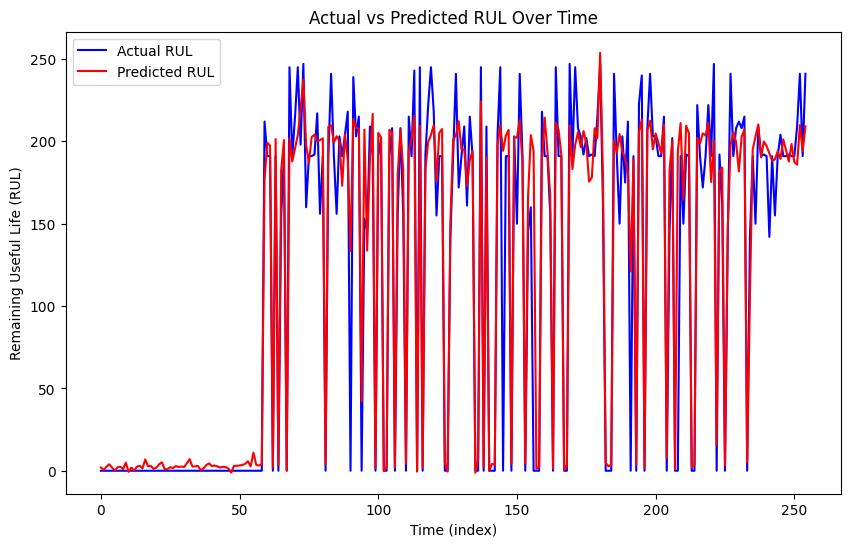

In [952]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual RUL', color='b')
plt.plot(y_pred, label='Predicted RUL', color='r')
plt.xlabel('Time (index)')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title('Actual vs Predicted RUL Over Time')
plt.legend()
plt.show()



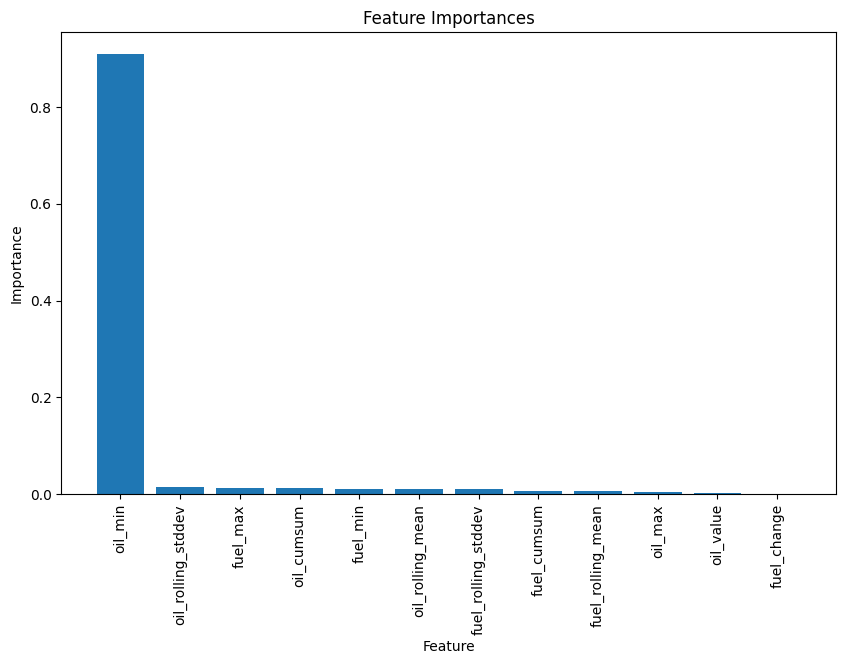

In [953]:
from sklearn.ensemble import RandomForestRegressor

# Example with RandomForestRegressor (assuming X_train_scaled and y_train are used)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Get feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X_train_scaled.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train_scaled.shape[1]), [features[i] for i in indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()
